Idea: we were interested in whether or not the tendency of men v. women to commute depended on time of day. We suspected that women might be more likely to commute by bike in the evening (towards home) rather than in the morning (towards work). We defined morning as a commute between 7-10 and evening as a commute between 4 and 7.

Alternative hypothesis: the proportion of women commuters will be greater in the evening than in the morning as compared to the proportion of male commuters

$H_a = P(women:evening)/P(women:commuters) - P(men:evening)/P(men:commuters) > 0$

Null hypothesis: the proportion of women commuters riding in the evening would be less than or equal to the proportion of male commuters riding in the evening

$H_0 = P(women:evening)/P(women:commuters) - P(men:evening)/P(men:commuters) \leq 0$

$\alpha = 0.5$

In [63]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import pylab as pl
import zipfile
import datetime as dt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [64]:
def getCitiBikeCSV(datestring):
    """the code from the citibikes gender ipython notebook wasn't working for us so we created a 
    new function to download and open the csv using the ZipFile module"""
    print ("Downloading", datestring) 
    !curl -O "https://s3.amazonaws.com/tripdata/{datestring}-citibike-tripdata.zip"
    zf = zipfile.ZipFile(datestring + '-citibike-tripdata.zip', 'r')
    zf.extractall(os.getenv('PUIDATA'))
    os.system("mv " + datestring +'-citibike-tripdata.zip ' + os.getenv('PUIDATA'))
    file_path = os.getenv('PUIDATA') + '/' + datestring + '-citibike-tripdata.csv'
    df = pd.read_csv(file_path, parse_dates=['starttime'])
    return df

In [65]:
datestring = '201502'
data = getCitiBikeCSV(datestring)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4708k  100 4708k    0     0  2087k      0  0:00:02  0:00:02 --:--:-- 2250k


In [66]:
columns_to_drop = list(data.columns) 

In [67]:
columns_to_drop.remove('starttime')
columns_to_drop.remove('gender')
# creates an inverse list to drop the unnecessary columns

In [68]:
data.drop(columns_to_drop, axis = 1, inplace = True)

In [69]:
data['date'] = pd.to_datetime(data['starttime'])

In [70]:
data['Time'],data['Date']= data['date'].apply(lambda x:x.time()), data['date'].apply(lambda x:x.date())
#http://stackoverflow.com/questions/24813673/split-datetime-column-into-a-date-and-time-python
data.head()

,starttime,gender,date,Time,Date
0,2015-02-01 00:00:00,2,2015-02-01 00:00:00,00:00:00,2015-02-01
1,2015-02-01 00:00:00,1,2015-02-01 00:00:00,00:00:00,2015-02-01
2,2015-02-01 00:01:00,2,2015-02-01 00:01:00,00:01:00,2015-02-01
3,2015-02-01 00:01:00,2,2015-02-01 00:01:00,00:01:00,2015-02-01
4,2015-02-01 00:01:00,1,2015-02-01 00:01:00,00:01:00,2015-02-01


In [71]:
def morn_eve(data): 
    #generates 1 for Morning, 2 for Evening, NA for neither
    col_num = data.gender.count()
    bands = []
    morn_start = dt.time(hour = 7)
    morn_end = dt.time(hour = 10)
    eve_start = dt.time(hour = 16)
    eve_end = dt.time(hour = 19)
    for x in range(col_num):
        if data.Time[x] >= morn_start and data.Time[x] <= morn_end:
            bands.append(1)
        elif data.Time[x] >= eve_start and data.Time[x] <= eve_end:
            bands.append(2)
        else: 
            bands.append(float('NaN'))
    data['morn_eve']= bands
    return data

In [72]:
data2 = morn_eve(data)

In [73]:
data2.dropna(axis = 0, inplace = True)
data2.reset_index
data3 = data2[data2['date'].dt.weekday < 5]
#removes all the neithers and weekends

In [74]:
label_names = ['Mon Morn', 'Mon Eve', 'Tues Morn', 'Tues Eve', 'Wed Morn', 'Wed Eve', 'Thurs Morn', 'Thurs Eve', 'Fri Morn', 'Fri Eve']

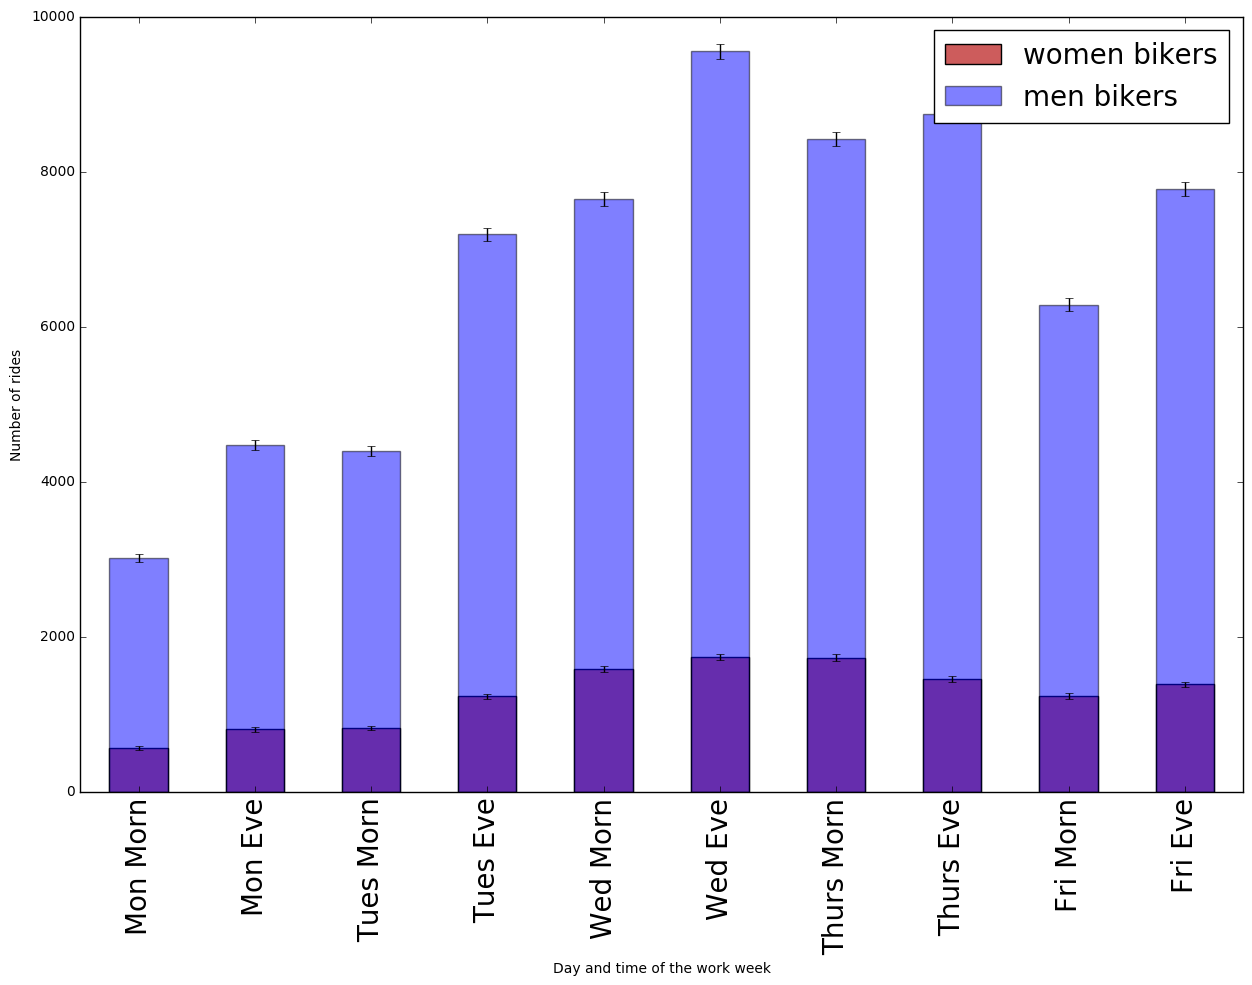

In [75]:
fig=pl.figure(figsize(15,10))

counts_w = data3['date'][data3['gender'] == 2].groupby([data3['date'].dt.weekday, data3['morn_eve']]).count()
norm_w = 1
error_w = np.sqrt(counts_w)
ax=((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women bikers')


counts_m = data3['date'][data3['gender'] == 1].groupby([data3['date'].dt.weekday, data3['morn_eve']]).count()
norm_m = 1
error_m=np.sqrt(counts_m)
((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m) / norm_m, (error_m) / norm_m)], label='men bikers')
ax.xaxis.set_ticklabels(label_names, fontsize=20)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day and time of the work week")
pl.legend(['women bikers','men bikers'],fontsize=20)


## Figure 1: Distribution of Citibikers by Commute Hours (Morning: 7-10, Evening 4-7) by gender, absolute values in February 2015

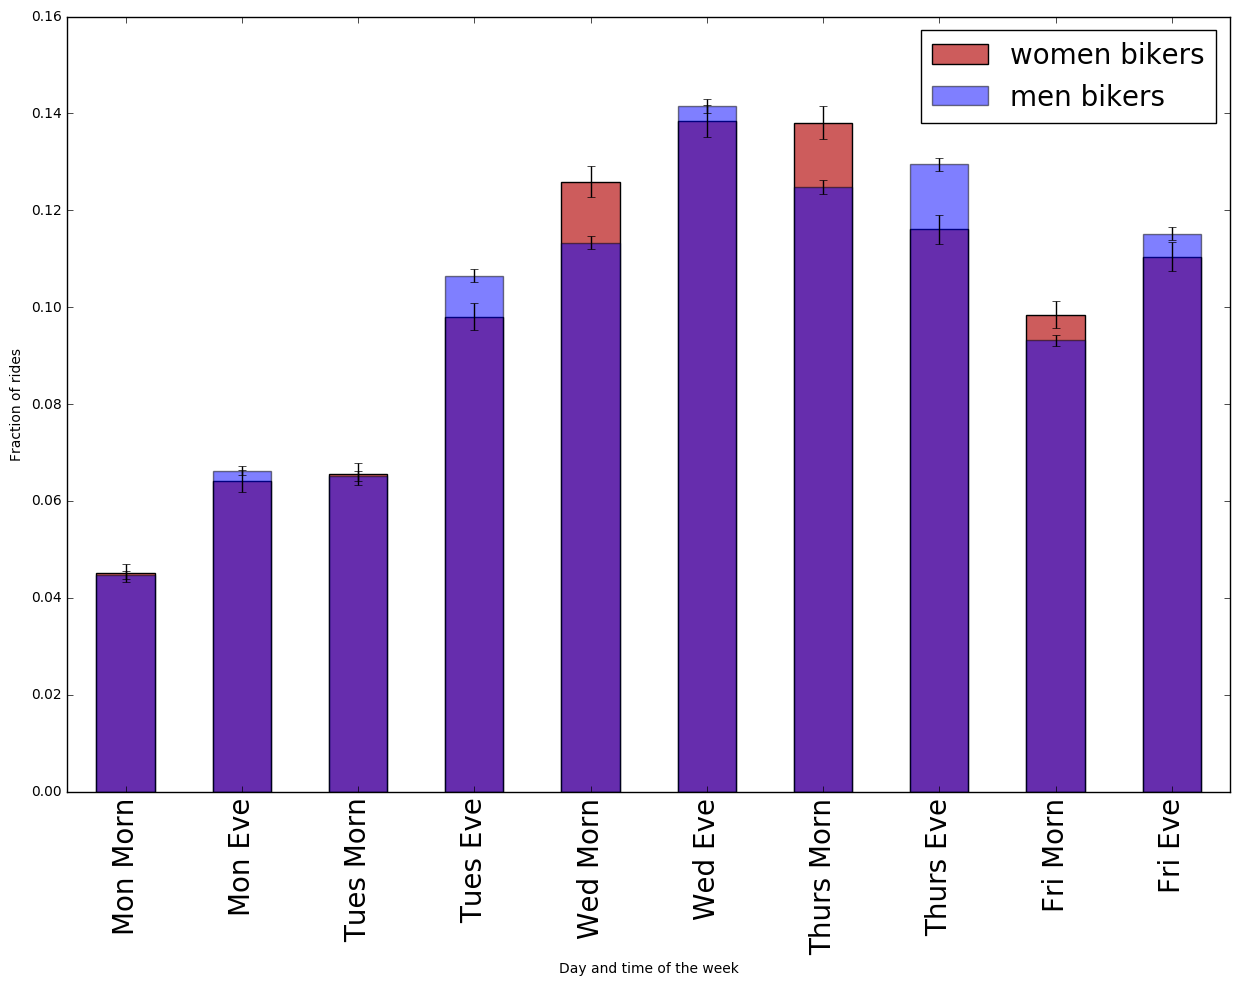

In [76]:
fig = pl.figure(figsize(15,10))

norm_w = counts_w.sum()
error_w = np.sqrt(counts_w)
((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women bikers')

norm_m = counts_m.sum()
ax = ((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m)/norm_m,(error_m)/norm_m)], label='men bikers')
ax.xaxis.set_ticklabels(label_names, fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day and time of the week")

pl.legend(['women bikers','men bikers'],fontsize=20)


## Figure 2: Distribution of Citibikers by Commute Hours (Morning: 7-10, Evening 4-7) by gender, normalized, in February 2015

Men: morning:0.792, evening:0.208, morning error:0.003, evening error:0.003
Women: morning:0.473, evening:0.527, morning error:0.006, evening error:0.006


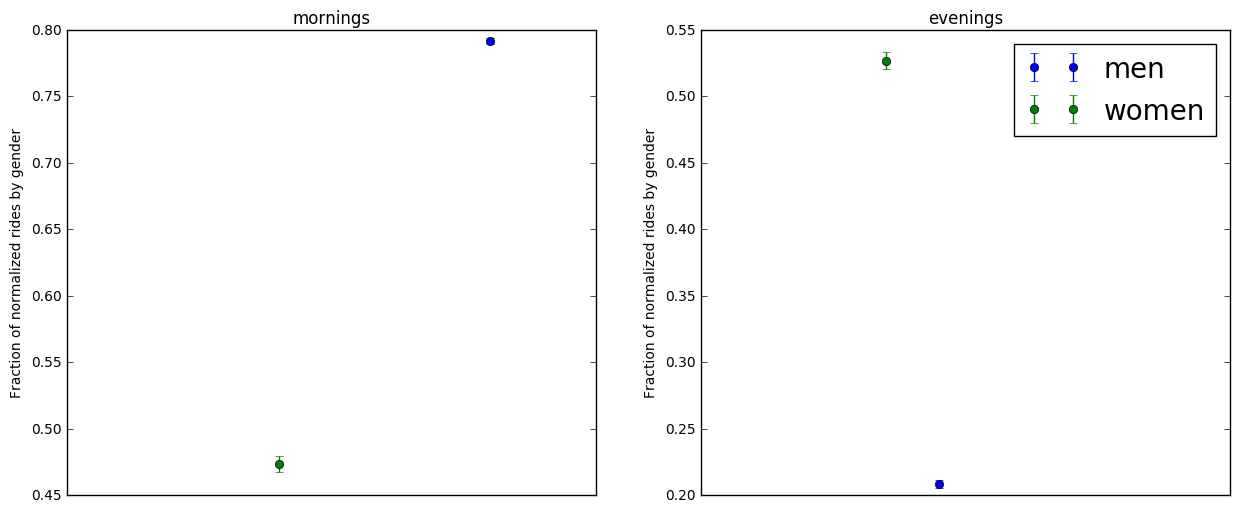

In [77]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])
morn_w = sum(counts_w[::2]) * 1.0 / norm_w
eve_w = sum(counts_w[1::2]) * 1.0 / norm_w
emorn_w = np.sqrt(sum(error_w[::2]**2)) / norm_w
eeve_w = np.sqrt(sum(error_w[1::2]**2)) / norm_w

morn_m = sum(counts_m[:-2]) * 1.0 / norm_m
eve_m = sum(counts_m[-2:]) * 1.0 / norm_m
emorn_m = np.sqrt(sum(error_m[::2]**2)) / norm_m
eeve_m = np.sqrt(sum(error_m[1::2]**2)) / norm_m

print("Men: morning:{0:.3f}, evening:{1:.3f}, morning error:{2:.3f}, evening error:{3:.3f}"\
      .format(morn_m, eve_m, emorn_m, eeve_m))
print("Women: morning:{0:.3f}, evening:{1:.3f}, morning error:{2:.3f}, evening error:{3:.3f}"\
      .format(morn_w, eve_w, emorn_w, eeve_w))

ax1.errorbar([0.4], [morn_m], yerr=[emorn_m], fmt='o', label='men')
ax1.errorbar([0.2], [morn_w], yerr=[emorn_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [eve_m], yerr=[eeve_m], fmt='o', label='men')
ax2.errorbar([0.2], [eve_w], yerr=[eeve_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax1.set_title("mornings")
ax2.set_title("evenings")
ax2.set_ylabel("Fraction of normalized rides by gender")
ax1.set_ylabel("Fraction of normalized rides by gender")

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 20)

## Figure 3: Fraction of Citibike bikers per gender in February 2014 for weekday Mornings (left) and weekday evenings (right)

In [78]:
p0 = eve_w
p1 = eve_m

In [79]:
p = (p0 * norm_w + p1 * norm_m) / (norm_w + norm_m)
SE = np.sqrt(p * (1.0 - p) * ((1.0 / norm_w) + (1.0 / norm_m)))
def zscore(p0, p1, SE):
    return (p0 - p1) / SE

In [80]:
print ('the Z statistic is {}'.format(zscore(p0, p1, SE)))

the Z statistic is 74.8207227307


# the Z statistic is much higher than 3, the highest z statistic in the table so we can reject the null hypothesis at the 0.05 level 

In [81]:
datestring = '201507'
data_2 = getCitiBikeCSV(datestring)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.9M  100 32.9M    0     0  44.4M      0 --:--:-- --:--:-- --:--:-- 55.3M


In [82]:
data_2.drop(columns_to_drop, axis = 1, inplace = True)

In [83]:
data_2['date'] = pd.to_datetime(data_2['starttime'])
data_2['Time'],data_2['Date']= data_2['date'].apply(lambda x:x.time()), data_2['date'].apply(lambda x:x.date())
#http://stackoverflow.com/questions/24813673/split-datetime-column-into-a-date-and-time-python
data_2.head()

,starttime,gender,date,Time,Date
0,2015-07-01 00:00:03,1,2015-07-01 00:00:03,00:00:03,2015-07-01
1,2015-07-01 00:00:06,1,2015-07-01 00:00:06,00:00:06,2015-07-01
2,2015-07-01 00:00:17,1,2015-07-01 00:00:17,00:00:17,2015-07-01
3,2015-07-01 00:00:23,1,2015-07-01 00:00:23,00:00:23,2015-07-01
4,2015-07-01 00:00:44,1,2015-07-01 00:00:44,00:00:44,2015-07-01


In [84]:
data_3 = morn_eve(data_2)

In [85]:
data_3.dropna(axis = 0, inplace = True)
data_3.reset_index
data_4 = data_3[data_3['date'].dt.weekday < 5]
#removes all the neithers and weekends

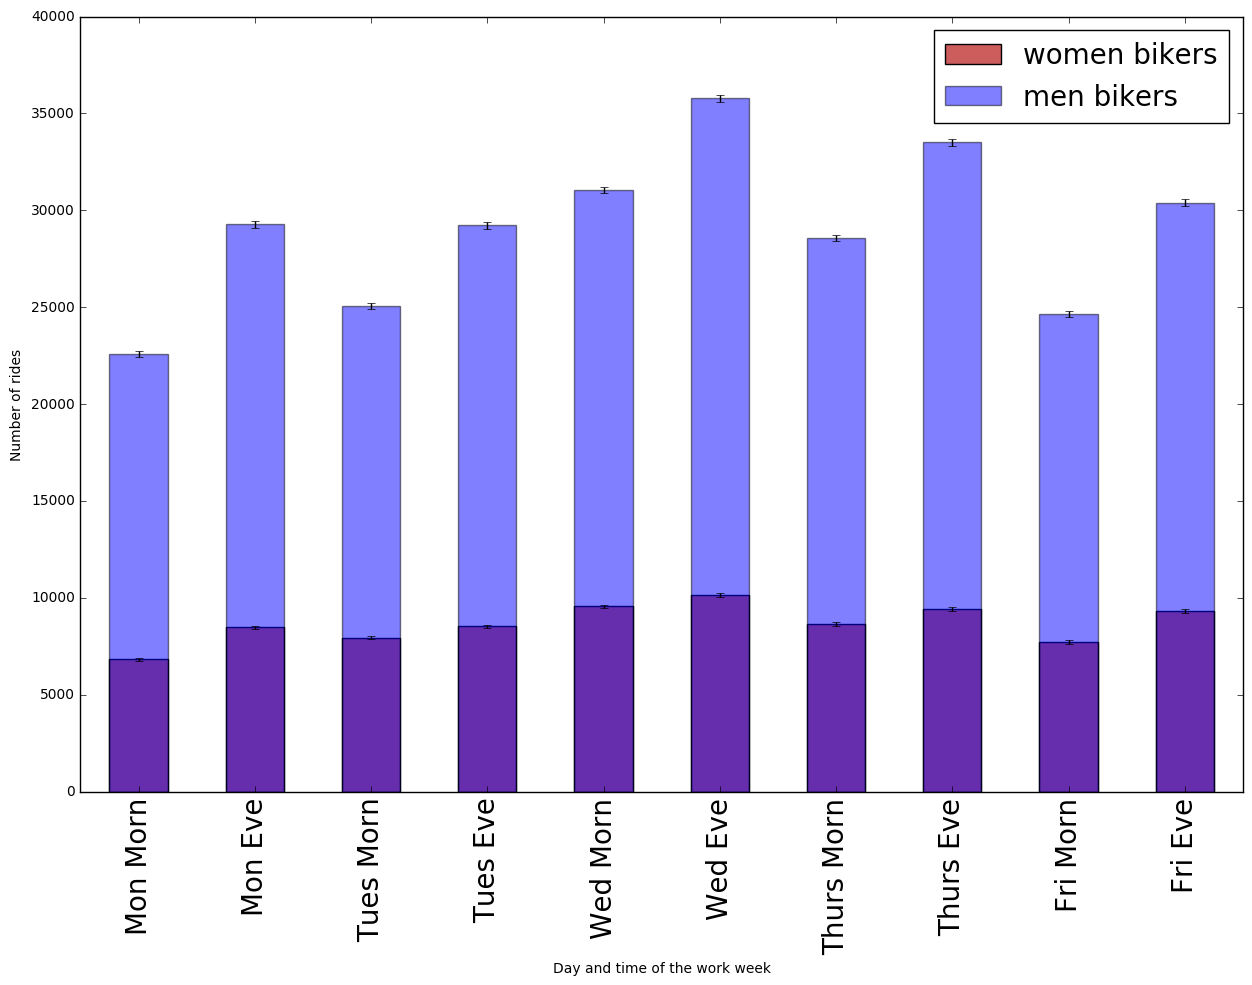

In [86]:
fig=pl.figure(figsize(15,10))

counts_w = data_4['date'][data_4['gender'] == 2].groupby([data_4['date'].dt.weekday, data_4['morn_eve']]).count()
norm_w = 1
error_w = np.sqrt(counts_w)
ax=((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women bikers')


counts_m = data_4['date'][data_4['gender'] == 1].groupby([data_4['date'].dt.weekday, data_4['morn_eve']]).count()
norm_m = 1
error_m=np.sqrt(counts_m)
((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m) / norm_m, (error_m) / norm_m)], label='men bikers')
ax.xaxis.set_ticklabels(label_names, fontsize=20)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day and time of the work week")
pl.legend(['women bikers','men bikers'],fontsize=20)

## Figure 4: Distribution of Citibikers by Commute Hours (Morning: 7-10, Evening 4-7) by gender, absolute values in July 2015

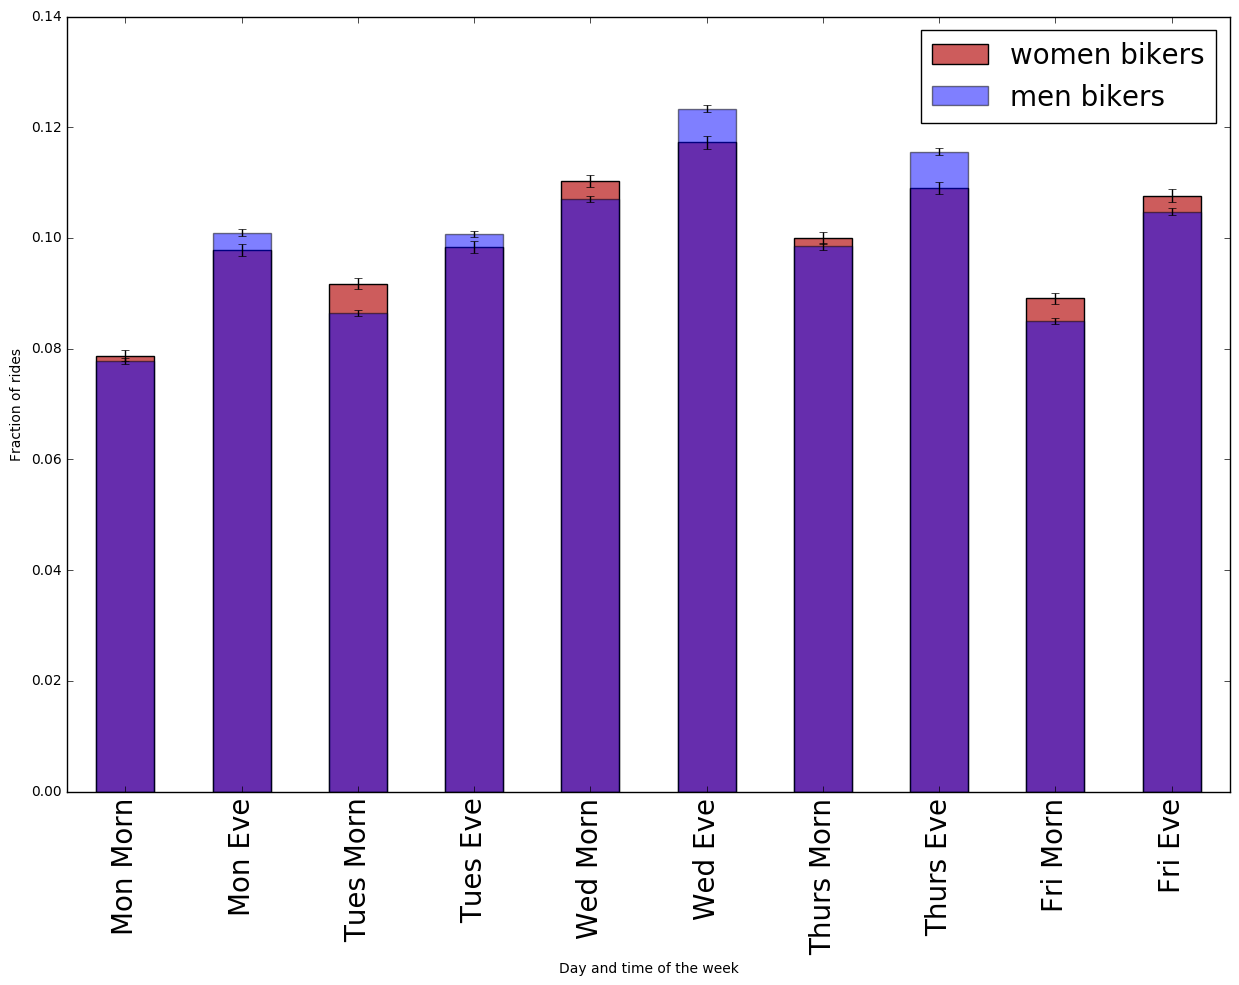

In [87]:
fig = pl.figure(figsize(15,10))

norm_w = counts_w.sum()
error_w = np.sqrt(counts_w)
((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women bikers')

norm_m = counts_m.sum()
ax = ((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m)/norm_m,(error_m)/norm_m)], label='men bikers')
ax.xaxis.set_ticklabels(label_names, fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day and time of the week")

pl.legend(['women bikers','men bikers'],fontsize=20)

## Figure 5: Distribution of Citibikers by Commute Hours (Morning: 7-10, Evening 4-7) by gender, normalized, in July 2015

Men: morning:0.810, evening:0.190, morning error:0.001, evening error:0.001
Women: morning:0.470, evening:0.530, morning error:0.002, evening error:0.002


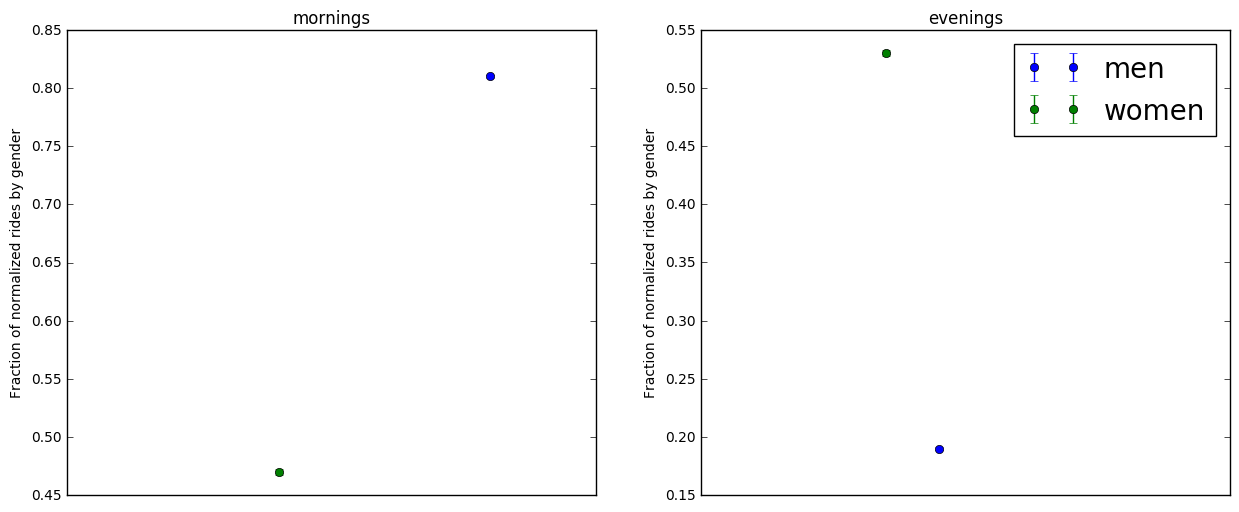

In [88]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])
morn_w = sum(counts_w[::2]) * 1.0 / norm_w
eve_w = sum(counts_w[1::2]) * 1.0 / norm_w
emorn_w = np.sqrt(sum(error_w[::2]**2)) / norm_w
eeve_w = np.sqrt(sum(error_w[1::2]**2)) / norm_w

morn_m = sum(counts_m[:-2]) * 1.0 / norm_m
eve_m = sum(counts_m[-2:]) * 1.0 / norm_m
emorn_m = np.sqrt(sum(error_m[::2]**2)) / norm_m
eeve_m = np.sqrt(sum(error_m[1::2]**2)) / norm_m

print("Men: morning:{0:.3f}, evening:{1:.3f}, morning error:{2:.3f}, evening error:{3:.3f}"\
      .format(morn_m, eve_m, emorn_m, eeve_m))
print("Women: morning:{0:.3f}, evening:{1:.3f}, morning error:{2:.3f}, evening error:{3:.3f}"\
      .format(morn_w, eve_w, emorn_w, eeve_w))

ax1.errorbar([0.4], [morn_m], yerr=[emorn_m], fmt='o', label='men')
ax1.errorbar([0.2], [morn_w], yerr=[emorn_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [eve_m], yerr=[eeve_m], fmt='o', label='men')
ax2.errorbar([0.2], [eve_w], yerr=[eeve_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax1.set_title("mornings")
ax2.set_title("evenings")
ax2.set_ylabel("Fraction of normalized rides by gender")
ax1.set_ylabel("Fraction of normalized rides by gender")

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 20)

## Figure 6: Fraction of Citibike bikers per gender in July 2015 for weekday Mornings (left) and weekday evenings (right)

In [89]:
p0_07 = eve_w 
p1_07 = eve_m
p_07 = (p0_07 * norm_w + p1_07 * norm_m) / (norm_w + norm_m)
SE_07 = np.sqrt(p * (1.0 - p) * ((1.0 / norm_w) + (1.0 / norm_m)))
print ('the Z statistic is {}'.format(zscore(p0_07, p1_07, SE_07)))


the Z statistic is 200.835505871


# the analysis also holds for this tested summer month as we can still reject the null hypothesis at an $\alpha = 0.5$ level

# checking effect size

In [90]:
r = lambda z, n0, n1 : z / np.sqrt(n0+n0)
h = lambda p0, p1: 2 * (np.arcsin(np.sqrt(p0)) - np.arcsin(np.sqrt(p1)))

In [61]:
norm_w02 = data3['date'][data3['gender'] == 2].groupby([data3['date'].dt.weekday, data3['morn_eve']]).count().sum()
norm_m02 = data3['date'][data3['gender'] == 1].groupby([data3['date'].dt.weekday, data3['morn_eve']]).count().sum()
r02 = r(zscore(p0, p1, SE), norm_w02, norm_m02)
r07 = r(zscore(p0_07, p1_07, SE_07), norm_w, norm_m)
print (r02, r07)

0.472829687452 0.482618722864


In [62]:
h02 = h(p0, p1)
h07 = h(p0_07, p1_07)
print (h02, h07)

0.676785322816 0.729661260797


# The size effect is firmly in the medium range for both the r calculation and the Cohen's h calculation